In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

image_path = 'C:/Users/Satyam Kumar/Downloads'
transform = transforms.Compose([transforms.ToTensor()])

mnist_train_ds = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=True)

mnist_test_ds  = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=True)

batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_ds, batch_size, shuffle = True)
test_dl  = DataLoader(mnist_test_ds, batch_size)

In [4]:
print(len(mnist_train_ds), len(mnist_test_ds))  # expect (60000, 10000)

x, y = mnist_train_ds[0]
x.shape, x.min().item(), x.max().item(), y
# Expect [1,28,28], values roughly in [-1, 1], label 0–9


60000 10000


(torch.Size([1, 28, 28]), 0.0, 1.0, 5)

In [5]:
import torch.nn as nn

hidden_units = [32, 16]
image_size = mnist_train_ds[0][0].shape
input_size = image_size[0]*image_size[1]*image_size[2]
all_layers = [nn.Flatten()]

for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit
all_layers.append(nn.Linear(hidden_units[-1], 10))

model = nn.Sequential(*all_layers).to(device)
model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=32, bias=True)
  (2): ReLU()
  (3): Linear(in_features=32, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=10, bias=True)
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
torch.manual_seed(1)
num_epochs = 20
for epoch in range(num_epochs):
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        x_batch = x_batch.to(device, non_blocking=True)
        y_batch = y_batch.to(device, non_blocking=True)
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum().item()
    accuracy_hist_train /= len(mnist_train_ds)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Accuracy: {accuracy_hist_train:.4f}")

Epoch 1/20, Train Accuracy: 0.8531
Epoch 2/20, Train Accuracy: 0.9287
Epoch 3/20, Train Accuracy: 0.9414
Epoch 4/20, Train Accuracy: 0.9506
Epoch 5/20, Train Accuracy: 0.9558
Epoch 6/20, Train Accuracy: 0.9592
Epoch 7/20, Train Accuracy: 0.9627
Epoch 8/20, Train Accuracy: 0.9649
Epoch 9/20, Train Accuracy: 0.9674
Epoch 10/20, Train Accuracy: 0.9690
Epoch 11/20, Train Accuracy: 0.9710
Epoch 12/20, Train Accuracy: 0.9728
Epoch 13/20, Train Accuracy: 0.9739
Epoch 14/20, Train Accuracy: 0.9750
Epoch 15/20, Train Accuracy: 0.9764
Epoch 16/20, Train Accuracy: 0.9777
Epoch 17/20, Train Accuracy: 0.9779
Epoch 18/20, Train Accuracy: 0.9798
Epoch 19/20, Train Accuracy: 0.9807
Epoch 20/20, Train Accuracy: 0.9813


In [8]:
def evaluate(model, test_dl, device):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in test_dl:
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            outputs = model(x_batch)
            _, predicted = torch.max(outputs, dim=1) 

            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = 100 * correct / total
    return accuracy

acc = evaluate(model, test_dl, device)
print(f"Test Accuracy: {acc:.2f}%")


Test Accuracy: 96.53%


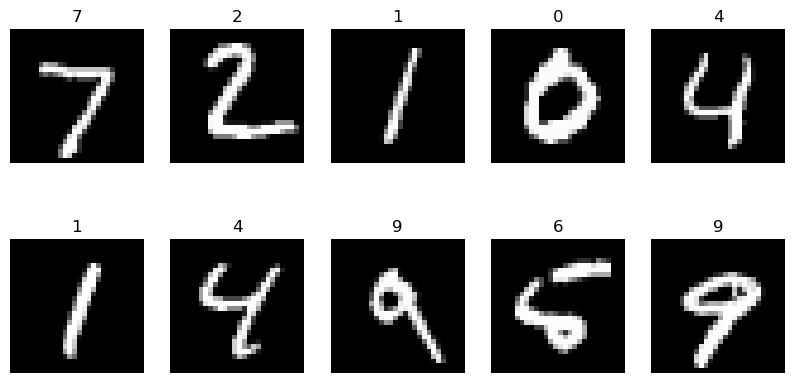

In [9]:
import matplotlib.pyplot as plt

x_batch, y_batch = next(iter(test_dl))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

model.eval()
with torch.no_grad():
    outputs = model(x_batch)
    _, preds = torch.max(outputs, 1)  

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = x_batch[i].cpu().squeeze(0) 
    ax.imshow(img, cmap="gray")
    ax.set_title(f"{preds[i].item()}")
    ax.axis("off")

plt.show()
